# Stokes equations #

This case study illustrates how to:

* Maintain symmetry when assembling a system of symmetric equations
  with essential (Dirichlet) boundary conditions
* Use an iterative solver explicitly for solving a linear system of equations
* Define a preconditioner explicitly using a form

## Strong form of the Stokes equations ##

The incompressible Stokes equations in strong form read: for a domain
$\Omega \subset \mathbb{R}^n$, find the velocity $\boldsymbol{u}$ and
the pressure $p$ satisfying

\begin{align}
   - \Delta \boldsymbol{u} + \nabla p &= f, \\
                    \nabla \cdot \boldsymbol{u} &= 0. \\
\end{align}

The first is the *momentum equation*, obtained from that in the 
Navier-Stokes equations
$$\rho\left(\dot{\boldsymbol{u}}+\boldsymbol{u}\cdot\boldsymbol{\nabla}\boldsymbol{u}\right) =\boldsymbol{\nabla}\cdot\boldsymbol{\sigma}(\boldsymbol{u},p)+\boldsymbol{f},$$

by setting the left-hand side to $\boldsymbol{0}$. The stress tensor $\boldsymbol{\sigma}$ is
\begin{equation}
  \boldsymbol{\sigma}(\boldsymbol{u}, p) = 2\mu\boldsymbol{\epsilon}(\boldsymbol{u}) - p\boldsymbol{I},
\end{equation}
where $\boldsymbol{\epsilon}(\boldsymbol{u})$ is the strain-rate tensor and $\mu$ is the dynamic viscosity.

A typical set of boundary conditions on the boundary $\partial
\Omega = \Gamma_{D} \cup \Gamma_{N}$ can be:

\begin{align}
              \boldsymbol{u} &= \boldsymbol{u}_0 \ \ \ \ {\rm on} \ \Gamma_{D}, \\
      \boldsymbol{\nabla} \boldsymbol{u} \cdot \boldsymbol{n} - p \boldsymbol{n} &= \boldsymbol{g}   \ \ \ \ \ \   {\rm on} \ \Gamma_{N}. \\
\end{align}

## Variational Forms of the Stokes equations ## 

The Stokes equations can easily formulated in a mixed variational
form; that is, a form where the two variables, the velocity and the
pressure, are approximated simultaneously. Using the abstract
framework, we have the problem: find $(\boldsymbol{u}, p) \in \mathcal{W}$ such that

$$a((\boldsymbol{u}, p), (\boldsymbol{v}, q)) = L((\boldsymbol{v}, q))$$

for all $$(\boldsymbol{v}, q) \in \mathcal{W}$$ where

\begin{align}
   a((\boldsymbol{u}, p), (\boldsymbol{v}, q))
   &= \int_{\Omega} \boldsymbol{\nabla} \boldsymbol{u} \cdot \boldsymbol{\nabla} \boldsymbol{v}
                    - \boldsymbol{\nabla} \cdot \boldsymbol{v} \ p
                    \pm \boldsymbol{\nabla} \cdot \boldsymbol{u} \ q \, {\rm d} \boldsymbol{x}, \\
   L((v, q))
   &= \int_{\Omega} \boldsymbol{f} \cdot \boldsymbol{v} \, {\rm d} x
      + \int_{\Gamma_N} \boldsymbol{g} \cdot \boldsymbol{v} \, {\rm d} \boldsymbol{s}. \\
\end{align}

The space $\mathcal{W}$ should be a mixed (product) function space: $\mathcal{W} = \boldsymbol{\mathcal{V}} \times \mathcal{Q}$ such that $\boldsymbol{u} \in \boldsymbol{\mathcal{V}}$ and $p \in \mathcal{Q}$.

Note: In the above, the sign in front of $(\boldsymbol{\nabla} \cdot \boldsymbol{u} \ q)$ can be chosen arbitrarily.
* If the sign is positive, the equation is nonsymmetric but positive definite. 
* If the sign is negative, the equation is symmetric but indefinite. This leads to a saddle point problem. The block corresponding to 
$\int_{\Omega} pq\, {\rm d} \boldsymbol{x}$ is $\boldsymbol{0}$.

We will use the latter.

In addition, it is critical that the bilinear form
$\int_{\Omega} \boldsymbol{\nabla} \cdot \boldsymbol{u} \ q\, {\rm d} \boldsymbol{x}$ is *coercive* in the sense that
$$ 
\inf_{q\in \mathcal{Q}}\sup_{\boldsymbol{v}\in \boldsymbol{\mathcal{V}}}
\frac{\int_{\Omega} \boldsymbol{\nabla} \cdot \boldsymbol{v} \ q \, {\rm d} \boldsymbol{x}}{\Vert \boldsymbol{v} \Vert_{L^2}\Vert q \Vert_{L^2}} \geq C
$$
for some $C>0$ independently of $h$. 

In the terminology of linear algebra, the smallest singular value of the off-diagonal blocks should be the same order as the smallest eigenvalue of the principle diagonal block. This is critical for stability and convergence.

This poses additional requirements on the mixture of the trial spaces for $\boldsymbol{u}$ and $p$.

![Image of Stable elements](https://raw.githubusercontent.com/unifem/fenics-notes/master/notebooks/stable_elements.png)
Source: [FEniCS Course lecture notes](https://fenicsproject.org/pub/course/lectures/2017-nordic-phdcourse/lecture_08_stokes.pdf)

## Preconditioning of the linear system of equations ## 

For the resulting linear system of equations, the following form
defines a suitable preconditioner:

$$b((\boldsymbol{u}, p), (\boldsymbol{v}, q)) = \int_{\Omega} \nabla \boldsymbol{u} \cdot \nabla \boldsymbol{v} + p \, q \, {\rm d} x$$

## Domain and boundary conditions ##

In this demo, we shall consider the following definitions of the input
functions, the domain, and the boundaries:

* $\Omega = [0,1]^3$  (a unit cube)
* $\Gamma_D = \{(x_0, x_1, x_2) \, | \, x_0 = 0 \, \text{or} \,
  x_0 = 1 \, \text{or} \, x_1 = 0 \, \text{or} \, x_1 = 1 \}$
* $\boldsymbol{u}_0 = (- \sin(\pi x_1), 0.0, 0.0)$ for $x_0 = 1$ and
  $\boldsymbol{u}_0 = (0.0, 0.0, 0.0)$ otherwise
* $\boldsymbol{f} = (0.0, 0.0, 0.0)$
* $\boldsymbol{g} = (0.0, 0.0, 0.0)$

## Implementation ## 

The Stokes equations as formulated above result in a system of linear
equations that is not positive-definite. Standard iterative linear
solvers typically fail to converge for such systems. Some care must
therefore be taken in preconditioning the systems of
equations. Moreover, not all of the linear algebra backends support
this. We, therefore, start by checking that either "PETSc" or "Epetra"
(from Trilinos) is available. We also try to pick MINRES Krylov
subspace method, which is suitable for symmetric indefinite problems.
If not available, costly QMR method is chosen.

In [1]:
from fenics import *

# Test for PETSc or Epetra
if not has_linear_algebra_backend("PETSc") and not has_linear_algebra_backend("Epetra"):
    info("FEniCS has not been configured with Trilinos or PETSc. Exiting.")
    exit()

if not has_krylov_solver_preconditioner("amg"):
    info("Sorry, this demo is only available when FEniCS is compiled with AMG "
         "preconditioner, Hypre or ML.")
    exit()

if has_krylov_solver_method("minres"):
    krylov_method = "minres"
elif has_krylov_solver_method("tfqmr"):
    krylov_method = "tfqmr"
else:
    info("Default linear algebra backend was not compiled with MINRES or TFQMR "
         "Krylov subspace method. Terminating.")
    exit()
    
krylov_method = "gmres"

Next, we define the mesh (a `UnitCubeMesh`) and a mixed finite element TH. We then build a `FunctionSpace` on this element. 
(This mixed finite element space is known as the
Taylor-Hood elements and is a stable, standard element pair for the
Stokes equations.)

In [2]:
# Load mesh
mesh = UnitCubeMesh(16, 16, 16)

# Build function space
P2 = VectorElement("Lagrange", mesh.ufl_cell(), 2)
P1 = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
TH = P2 * P1
W = FunctionSpace(mesh, TH)

### Useful Functions ###

On the mixed finite element space, we can use `sub` to access subspaces:
``` 
W.sub(0)
W.sub(1)
```

We can use `split` to split the variables.
``` 
up = Function(W)
u, p = split(up)
```

Next, we define the boundary conditions.

In [3]:
# Boundaries
def right(x, on_boundary): return x[0] > (1.0 - DOLFIN_EPS)
def left(x, on_boundary): return x[0] < DOLFIN_EPS
def top_bottom(x, on_boundary):
    return x[1] > 1.0 - DOLFIN_EPS or x[1] < DOLFIN_EPS

# No-slip boundary condition for velocity
noslip = Constant((0.0, 0.0, 0.0))
bc0 = DirichletBC(W.sub(0), noslip, top_bottom)

# Inflow boundary condition for velocity
inflow = Expression(("-sin(x[1]*pi)", "0.0", "0.0"), degree=2)
bc1 = DirichletBC(W.sub(0), inflow, right)

bc2 = DirichletBC(W.sub(0), noslip, left)

# Collect boundary conditions
bcs = [bc0, bc1, bc2]

The bilinear and linear forms corresponding to the weak mixed
formulation of the Stokes equations are defined as follows:

In [4]:
# Define variational problem
u, p = TrialFunctions(W)
v, q = TestFunctions(W)
f = Constant((0.0, 0.0, 0.0))
a = inner(grad(u), grad(v))*dx - div(v)*p*dx - q*div(u)*dx
L = inner(f, v)*dx

We can now use the same `TrialFunctions` and
`TestFunctions` to define the preconditioner matrix. We first define the form
corresponding to the expression for the preconditioner (given in the
initial description above):

In [5]:
# Form for use in constructing preconditioner matrix
b = inner(grad(u), grad(v))*dx + p*q*dx

Next, we want to assemble the matrix corresponding to the bilinear
form and the vector corresponding to the linear form of the Stokes
equations. Moreover, we want to apply the specified boundary
conditions to the linear system. However, `assembling` the matrix and vector and applying a `DirichletBC` separately will possibly result 
in a non-symmetric system of equations. Instead, we can use the `assemble_system` function to assemble both the
matrix `A`, the vector `bb`, and apply the boundary conditions
`bcs` in a symmetric fashion:

In [6]:
# Assemble system
A, bb = assemble_system(a, L, bcs)

We assemble the preconditioner matrix ``P`` using the linear
form ``b``:

In [7]:
# Assemble preconditioner system
P = assemble(b)

Next, we specify the iterative solver we want to use, in this case a
`KrylovSolver`. We associate the
left-hand side matrix ``A`` and the preconditioner matrix ``P`` with
the solver by calling `solver.set_operators`.

In [8]:
# Create Krylov solver and AMG preconditioner
solver = KrylovSolver(krylov_method, "amg")

# Associate operator (A) and preconditioner matrix (P)
solver.set_operators(A, P)

We are now almost ready to solve the linear system of equations. It
remains to specify a `Vector` for
storing the result. For easy manipulation later, we can define a
`Function` and use the
vector associated with this Function. The call to
`solver.solve` then looks as follows:

In [9]:
# Solve
U = Function(W)
solver.solve(U.vector(), bb)

1

Finally, we can play with the result in different ways:

In [10]:
# Get sub-functions
u, p = U.split()

# Save solution in VTK format
ufile_pvd = File("velocity.pvd")
ufile_pvd << u
pfile_pvd = File("pressure.pvd")
pfile_pvd << p

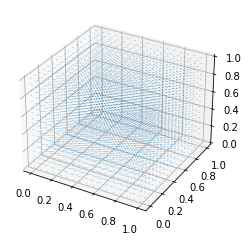

In [11]:
# Plot solution
%matplotlib inline
plot(u)

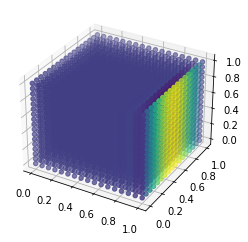

In [12]:
plot(p)

**Acknowledgment**: This notebook was adapted from the [FEniCS/DOLFIN demo on Stokes equations](https://fenicsproject.org/docs/dolfin/2019.1.0/python/demos/stokes-iterative/demo_stokes-iterative.py.html) and the [FEniCS Course for Stokes Equations](https://fenicsproject.org/pub/course/lectures/2017-nordic-phdcourse/lecture_08_stokes.pdf).